In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Get Dataset file path
df_path = "/content/drive/MyDrive/KwhConsumption.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading csv file as a pandas dataframe(df)
df = pd.read_csv(df_path, header=0)

#Removing Unnamed Column
del df["Unnamed: 0"]

df.head()

,TxnDate,TxnTime,Consumption
0,01 Feb 2022,14:41:48,1.016
1,01 Feb 2022,17:28:44,0.928
2,01 Feb 2022,19:51:07,0.988
3,01 Feb 2022,07:26:39,1.126
4,01 Feb 2022,05:20:47,0.886


In [ ]:
#Combining Date & time Object feature into datetime64 datatype
df.loc[:,"Datetime"]=df["TxnDate"]+' '+df["TxnTime"]

#Creating a simpler dataframe
df2=df[["Datetime","Consumption"]]

#Since this is a TimeSeries problem, we have to parse 'Datetime' column
from datetime import datetime, date 

df2['Datetime'] = pd.to_datetime(df2['Datetime'])
df2.head().style.set_properties(subset=['Datetime'], **{'background-color': 'dodgerblue'})

,Datetime,Consumption
0,2022-02-01 14:41:48,1.016000
1,2022-02-01 17:28:44,0.928000
2,2022-02-01 19:51:07,0.988000
3,2022-02-01 07:26:39,1.126000
4,2022-02-01 05:20:47,0.886000


**DATA VISUALIZATION**

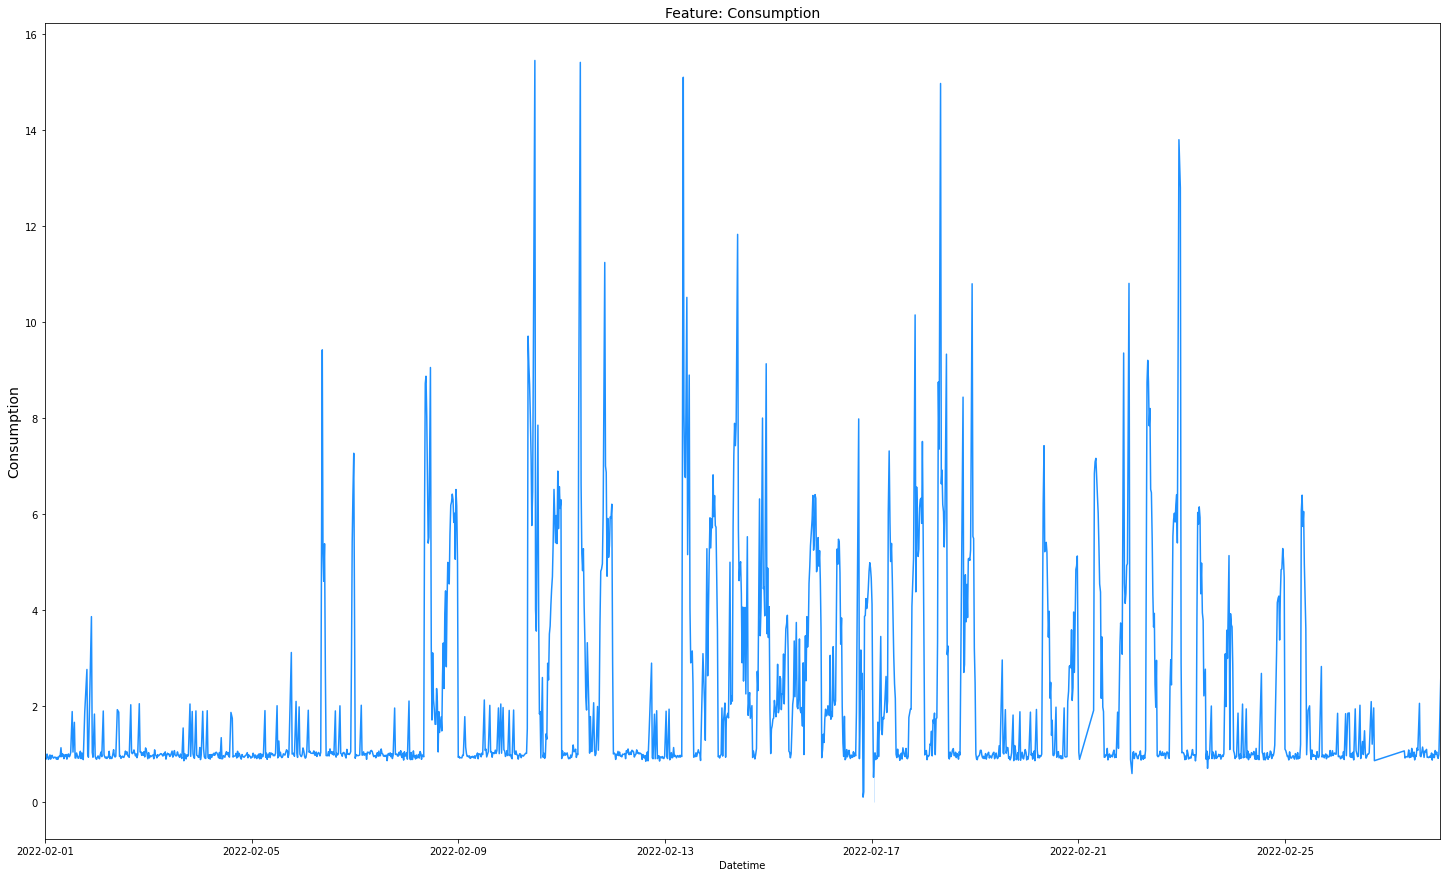

In [ ]:
#To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 15))

#Despite the fact there is only one plottable column, we'll keep these lines as a general way to do it
for i, column in enumerate(df2.drop('Datetime', axis=1).columns):
    sns.lineplot(x=df2['Datetime'], y=df2[column].fillna(method='ffill'), ax=ax, color='dodgerblue')   #We need to write ax=ax[i] if there were more subplots
    ax.set_title('Feature: {}'.format(column), fontsize=14)
    ax.set_ylabel(ylabel=column, fontsize=14)
    ax.set_xlim([date(2022, 2, 1), date(2022, 2, 28)])

**DATA PREPROCESSING**

In [ ]:
#The chronological order can be achieved by sorting the dataframe by the timestamps
#Equidisant timestamps indicate constant time intervals

df = df2.sort_values(by='Datetime')  #We get back to the widely known 'df' nickname ;)

#Check time intervals
df['delta'] = df['Datetime'] - df['Datetime'].shift(1)
avg_timestamp = df['delta'].sum()/df['delta'].count()

df[['Datetime', 'delta']].head()

,Datetime,delta
48,2022-02-01 00:17:01,NaT
27,2022-02-01 00:36:31,0 days 00:19:30
5,2022-02-01 00:58:08,0 days 00:21:37
32,2022-02-01 01:18:41,0 days 00:20:33
35,2022-02-01 01:38:01,0 days 00:19:20


In [ ]:
#We have uneven time intervals. We will take a constant average time interval and resample the data.

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace = True)
df.resample(avg_timestamp).sum()

,Consumption
Datetime,
2022-02-01 00:00:00.000000000,0.900
2022-02-01 00:23:03.861476817,0.890
2022-02-01 00:46:07.722953634,0.994
2022-02-01 01:09:11.584430451,0.942
2022-02-01 01:32:15.445907268,0.882
...,...
2022-02-28 22:01:10.554092031,1.020
2022-02-28 22:24:14.415568848,2.040
2022-02-28 22:47:18.277045665,1.064


In [ ]:
#Note that after resampling, our dataframe will use Datetime as index
#That's not our intention, so we need to reset the index at the end

df = df.resample(avg_timestamp).sum().reset_index()

*HANDLE MISSINGS*

In [ ]:
#Let's see if there is any NaN value to be filled

df.isna().sum()

Datetime       0
Consumption    0
dtype: int64

*SMOOTHING DATA / RESAMPLING*

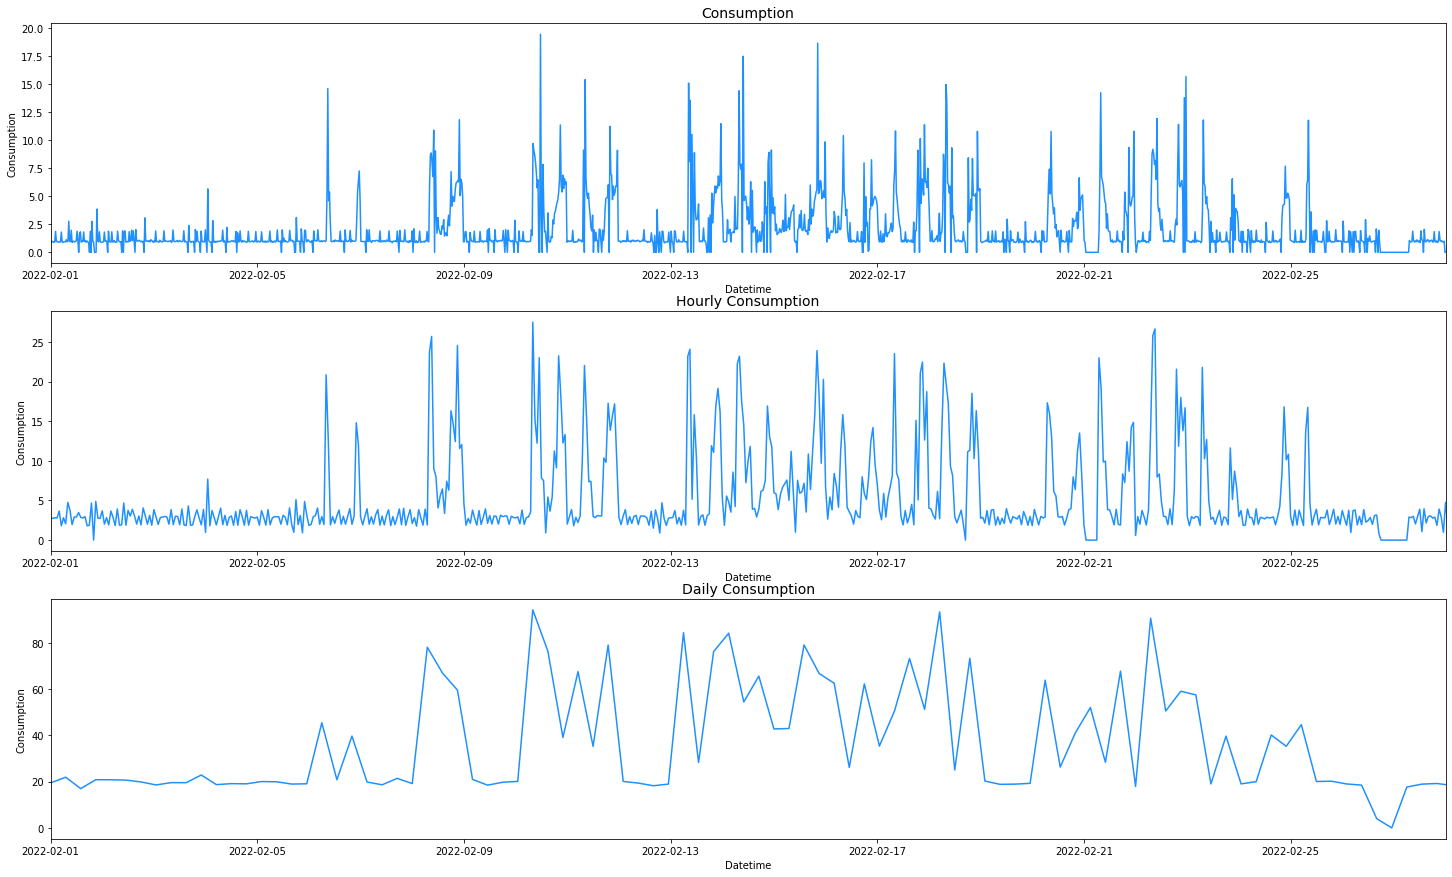

In [ ]:
#Resampling can provide additional information on the data
#Downsampling is when the frequency of samples is decreased (e.g. days to weeks)

f, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 15))

sns.lineplot(df['Datetime'], df['Consumption'], color='dodgerblue', ax=ax[0])
ax[0].set_title('Consumption', fontsize=14)

resampled_df = df[['Datetime','Consumption']].resample('1H', on='Datetime').sum().reset_index(drop=False)
sns.lineplot(resampled_df['Datetime'], resampled_df['Consumption'], color='dodgerblue', ax=ax[1])
ax[1].set_title('Hourly Consumption', fontsize=14)

resampled_df = df[['Datetime','Consumption']].resample('7H', on='Datetime').sum().reset_index(drop=False)
sns.lineplot(resampled_df['Datetime'], resampled_df['Consumption'], color='dodgerblue', ax=ax[2])
ax[2].set_title('Daily Consumption', fontsize=14)

for i in range(3):
    ax[i].set_xlim([date(2022, 2, 1), date(2022, 2, 28)])

plt.show()

In [ ]:
# As we can see, downsample to hourly could smooth the data and help with the analysis
downsample = df[['Datetime', 'Consumption']].resample('1H', on='Datetime').mean().reset_index(drop=False)

df = downsample.copy()

*STATIONARITY*

A timeseries is stationary if the properties of the time series (for example, mean, variance, autocorrelation, etc.) do not change with time.

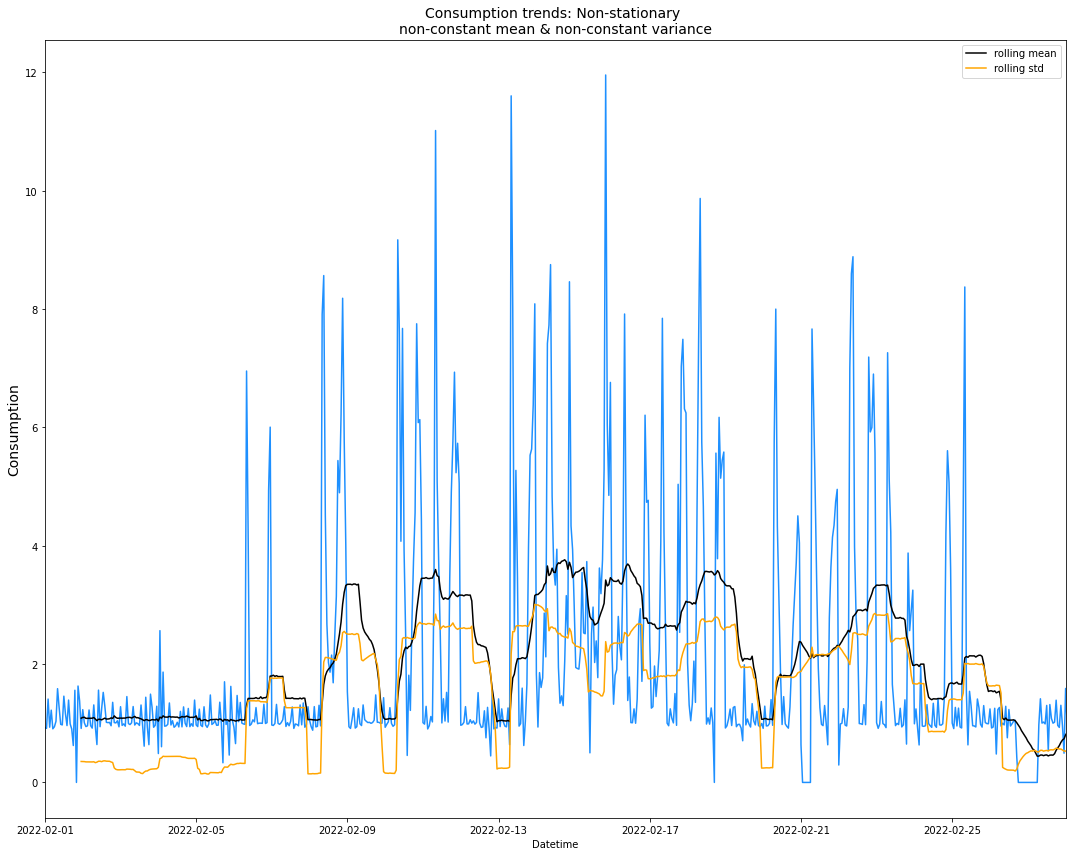

In [ ]:
#The first check for stationarity is visual:
#We plot time series and check for trends or seasonality

# February has a seasonality of approximately 24 hours
rolling_window = 24
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Datetime'], y=df['Consumption'], ax=ax, color='dodgerblue')
sns.lineplot(x=df['Datetime'], y=df['Consumption'].rolling(rolling_window).mean(), ax=ax, color='black', label='rolling mean')
sns.lineplot(x=df['Datetime'], y=df['Consumption'].rolling(rolling_window).std(), ax=ax, color='orange', label='rolling std')
ax.set_title('Consumption trends: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax.set_ylabel(ylabel='Consumption', fontsize=14)
ax.set_xlim([date(2022, 2, 1), date(2022, 2, 28)])

plt.tight_layout()
plt.show()

In this visual check, we can see that the features don't have constant mean and std, plus they aren't even close to it.

The data is not stationary, even though we want to use a model such as ARIMA (that requires this characteristic). One method is transformation, which consists of log or square root to stabilize non-constant variance.

In [ ]:
#We'll first need a function to visualize the results from the statistical Augmented Dickey-Fuller unit root test:

from statsmodels.tsa.stattools import adfuller

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['Datetime'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

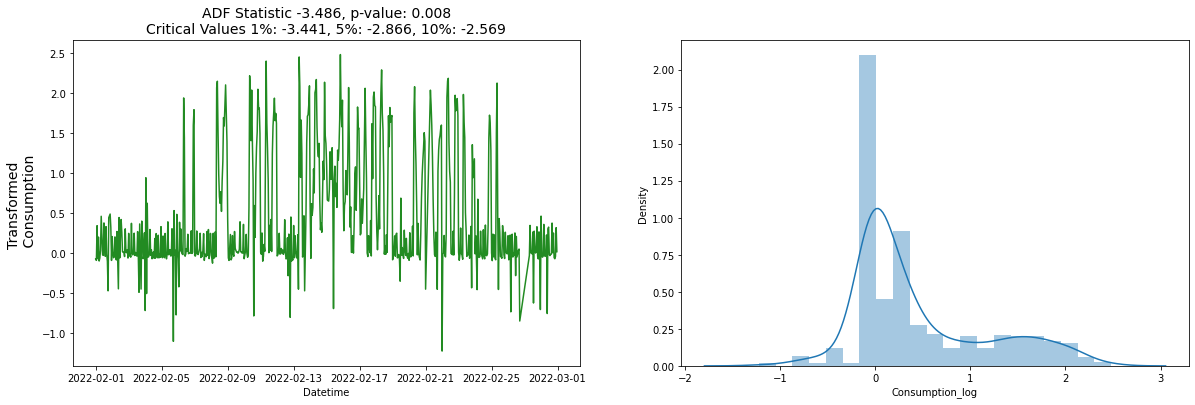

In [ ]:
# Log Transform of absolute values (Log transform of negative values will return NaN)
df['Consumption_log'] = np.log(abs(df['Consumption']))
df = df.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()  #There may be any -inf result that we want to get rid of

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['Consumption_log'], 'Transformed \n Consumption', ax[0])

sns.distplot(df['Consumption_log'], ax=ax[1])

As the p-value is less or equal than significance level (default: 0.05), the data are now stationary.

More precisely, as the ADF Statistic is less than the 1% Critical Value (-3.486 < 3.441), so there is more than 99% probability for data being stationary.

The Dickey-Fuller distribution on the right just shows the way critical values are retrieved. These are the values such that 1%, 5% or 10% of the probability mass is to the left.

**FEATURE ENGINEERING**

In [ ]:
df['year'] = pd.DatetimeIndex(df['Datetime']).year
df['month'] = pd.DatetimeIndex(df['Datetime']).month
df['day'] = pd.DatetimeIndex(df['Datetime']).day
df['hour'] = pd.DatetimeIndex(df['Datetime']).hour

df[['Datetime', 'year', 'month', 'day', 'hour']].head()

,Datetime,year,month,day,hour
0,2022-02-01 00:00:00,2022,2,1,0
1,2022-02-01 01:00:00,2022,2,1,1
2,2022-02-01 02:00:00,2022,2,1,2
3,2022-02-01 03:00:00,2022,2,1,3
4,2022-02-01 04:00:00,2022,2,1,4


*ENCODING CYCLICAL FEATURES*

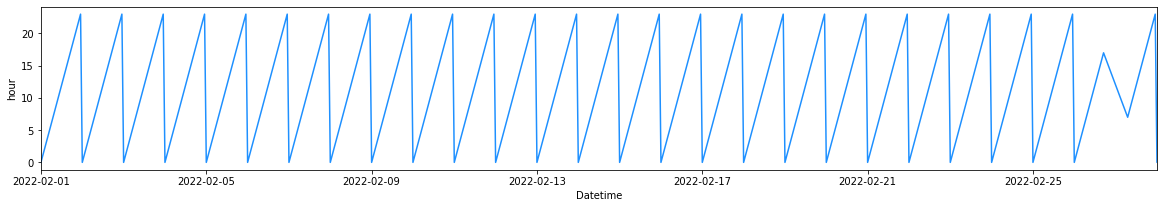

In [ ]:
#Many features commonly found in datasets are cyclical in nature. The best example of such a feature is of course time
#We need to let the algorithm know that such features occur in cycles, so it doesn't take it as an outcome of the model

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['Datetime'], y=df['hour'], color='dodgerblue')
ax.set_xlim([date(2022, 2, 1), date(2022, 2, 28)])
plt.show()

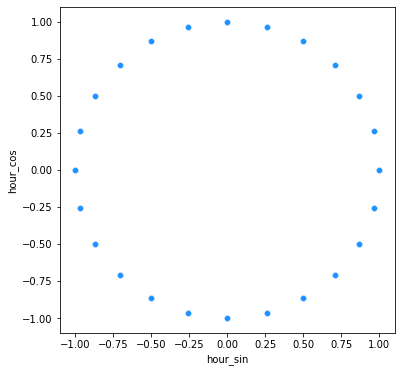

In [ ]:
#It plays a key role to keep track of cyclical features and process them analogously to transforming non-stationary variables into stationary ones
#Let's encode this cyclical feature:

hours_in_day = 24
df['hour_sin'] = np.sin(2*np.pi*df['hour']/hours_in_day)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/hours_in_day)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.hour_sin, y=df.hour_cos, color='dodgerblue')
plt.show()

*TIMESERIES DECOMPOSITION*

In [ ]:
#The goal of time series analysis is to decompose a time series into its 
#constituent features and develop mathematical models for each of them

from statsmodels.tsa.seasonal import seasonal_decompose

column =  'Consumption'

decomp = seasonal_decompose(df[column], period=24, model='additive', extrapolate_trend='freq')
df[f"{column}_trend"] = decomp.trend
df[f"{column}_seasonal"] = decomp.seasonal

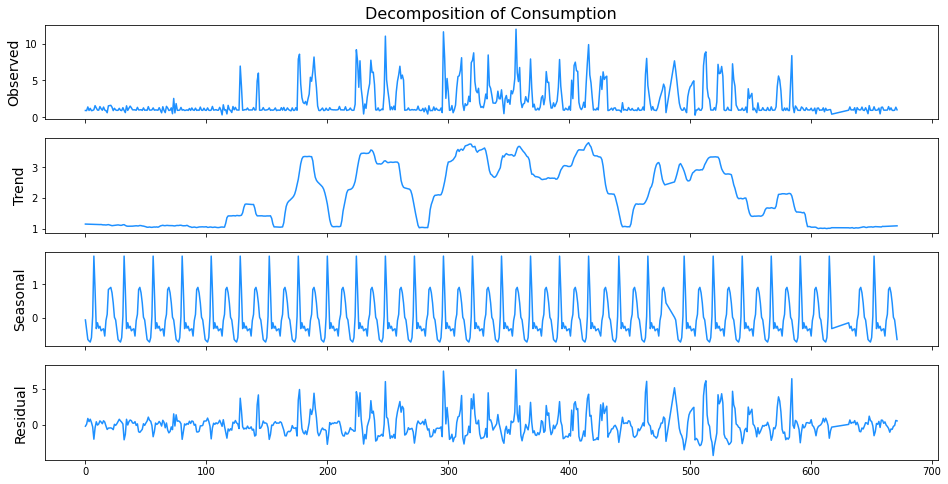

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))


res = seasonal_decompose(df[column], period=24, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of {}'.format(column), fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

The Consumption dataset describes the consumption of electricity at each moment over a period of time. The real graph is the 'Observed' one.


The trend-cycle shows the overall movement in the series, ignoring the seasonality and any small random fluctuations. So, it tends to over-smooth rapid rises and falls in the data. We don't get much insight from this graph.


We can see that the seasonality information extracted from the series does seem reasonable, so there is more consumption at certain hours of the day.


The residuals are also interesting, showing periods of high variability in the middle days of the series. This may be due to a greater consumption on weekends. Moreover, Valentine's day implies a significant and irregular electricity expenditure (https://business.directenergy.com/blog/2018/february/how-much-energy-does-it-take-to-fuel-valentines-day).

**EXPLORATORY DATA ANALYSIS**

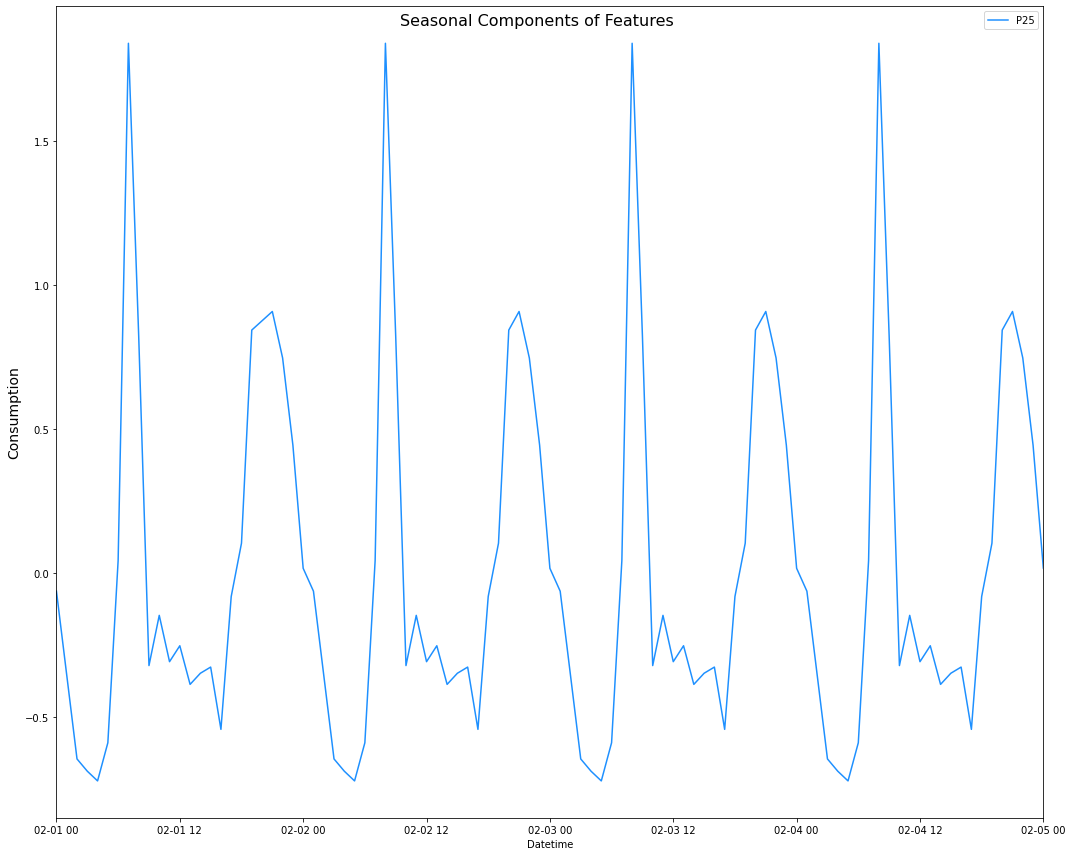

In [ ]:
#Now, we are going to plot the data and try to extract some knowledge
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)


sns.lineplot(x=df['Datetime'], y=df[column + '_seasonal'], ax=ax, color='dodgerblue', label='P25')
ax.set_ylabel(ylabel=column, fontsize=14)
ax.set_xlim([date(2022, 2, 1), date(2022, 2, 5)])  #We limit the range so to observe better the details
    
plt.tight_layout()
plt.show()

As we can observe, consumption reaches its 1st maximum around 10:00h and its 2nd maximum at 22h. On the other hand, it reaches its minimum around 04:00h.

*AUTOCORRELATION ANALYSIS*

Autocorrelation (ACF) is the correlation of a timeseries at two different points in time (also known as lags). Each value of correlation between two lags includes information about intermediate lags. The plot can be used to spot seasonality and trends/stationarity.

Partial autocorrelation (PACF) is the correlation between the time series at two different lags not considering the effect of any intermediate lags. PACF's primary use is in estimating the number of auto-regressors components for ARIMA forecasting model. Nonetheless, we prefer to use Auto-ARIMA method so to obtain these autoregressors through a grid search.

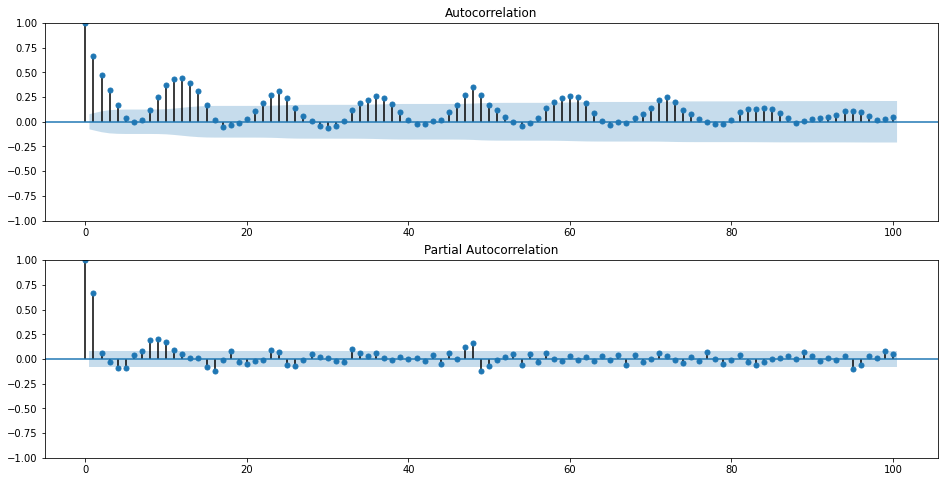

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['Consumption_log'], lags=100, ax=ax[0])
plot_pacf(df['Consumption_log'], lags=100, ax=ax[1])

plt.show()

On the first graph, we can see that not every autocorrelation value is very close to zero. That implies some randomness in the data, but this timeseries isn't random. Plus there isn't any trend upwards or downwards as the lags increase. This points that our data are stationary and valid for modelling.


As for the second graph, the blue region is where lags are no longer statistically significant. We see that lag 1 is highly correlated and there are other highly correlated lags later in time which are probably due to seasonal affects. This plot (which might assist us in determining ARIMA's AR term) drops abruptly after one lag. It supposedly implies that we should use an AR(1) model.



Anyhow, I would always prefer auto.arima() over parsing (P)ACF plots myself, i.e., the Box-Jenkins approach. It is built by experts with a lot of experience, and it truly is a gold standard for ARIMA modeling.

**MODELING**

In [ ]:
#First of all we are going to see how does cross-validation technique works in TimeSeries Analysis.

from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['Datetime']
y = df['Consumption']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [ ]:
print(folds)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)


We depict two ways of splitting data subsets if we were to use cross-validation to average each algorithm's performance:

· Timeseries split allows us to inspect how the model fares on different days, though it may produce data leakage - when the data you are using to train a machine learning algorithm happens to have the information you are trying to predict.

· Blocked cross validation solves data leakage issue, but may be computationally expensive.

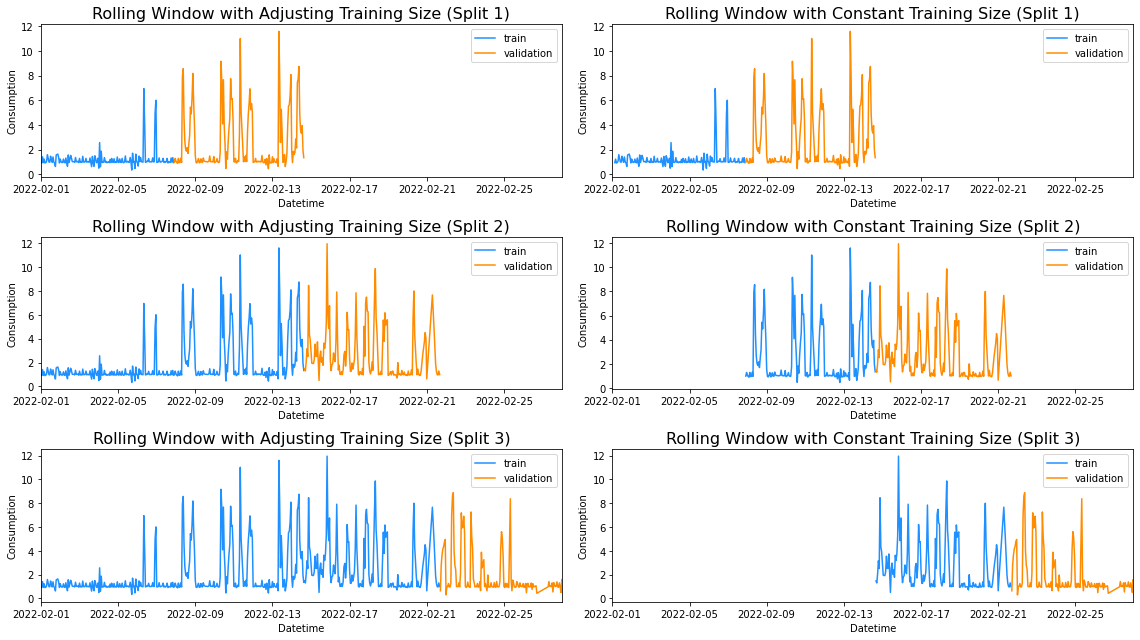

In [ ]:
# The idea with this plot is to understand which train and test set are we using to fit the model in each iteration.

f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

# print(ax) shows that ax is now a two-dimensional array. nrows and ncols are both greater than 1

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] #train and validation data splits
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i,0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i,1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i,0].set_xlim([date(2022, 2, 1), date(2022, 2, 28)])
    ax[i,1].set_xlim([date(2022, 2, 1), date(2022, 2, 28)])
    
plt.tight_layout()
plt.show()

*MODELS FOR UNIVARIATE TIMESERIES*

We use the past values to make future predictions, and so we will need to split the data in time. We train on the data earlier in the time series and test on the data that comes later. In this case, we aren't using cross-validation.

In [ ]:
#We choose to have a 85% of the data as training data and the other 15% as test data

train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['Datetime', 'Consumption']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))  #From 651 datapoints, we have 553 training ones and 98 test ones

553 98


*1st MODEL - PROPHET*

In [ ]:
!pip uninstall pystan
!pip install pystan~=2.14
!pip install fbprophet
from fbprophet import Prophet

Found existing installation: pystan 2.19.1.1
Uninstalling pystan-2.19.1.1:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/pystan-2.19.1.1.dist-info/*
    /usr/local/lib/python3.8/dist-packages/pystan/*
Proceed (y/n)? y
  Successfully uninstalled pystan-2.19.1.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pystan-2.19.1.1-cp38-cp38-manylinux1_x86_64.whl (62.6 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
!pip install colorama
from colorama import Fore

# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 1.5850830242484863


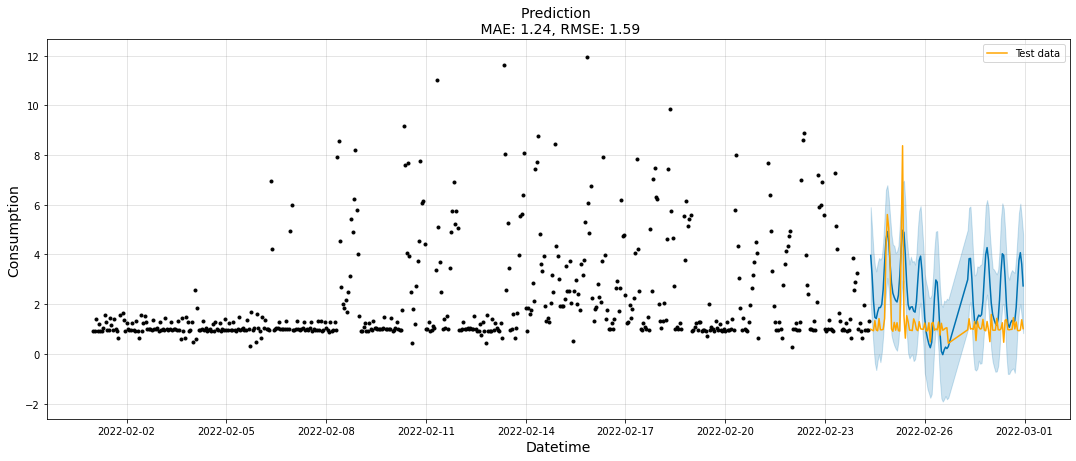

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)  #The prediction lineplot is the blue one
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Test data') 

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Datetime', fontsize=14)
ax.set_ylabel(ylabel='Consumption', fontsize=14)

plt.show()

*2nd MODEL - AUTO-ARIMA*

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# auto.arima applies a range of techniques to provide the best arima settings (p,d,q) 

#from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2113.582, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2795.069, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2112.859, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2413.122, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2113.774, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2116.554, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2057.039, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2372.704, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2057.036, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2058.303, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2058.498, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2057.184, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2055.540, Time=0.83 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2058.572, Time=3.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept

AutoARIMA validates that (3,0,1) is the best configuration for the hyperparameters (p,d,q).

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 1.3992960403123604
MAE: 1.2448119669937274


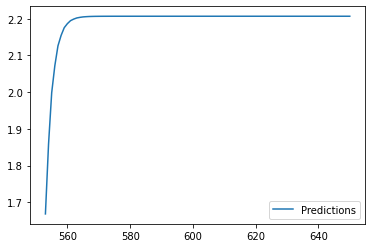

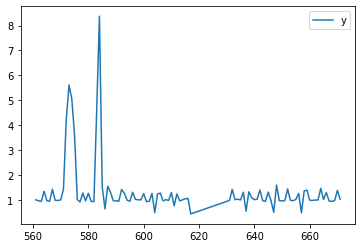

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(y_train, order=(3,0,1))
model_fit = model.fit()

start = len(y_train)
end = len(y_train) + len(y_valid) - 1
  
# Predictions for one-year against the test set
predictions = model_fit.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
y_valid.plot(legend = True)


# Load specific evaluation tools
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
score_rmse = math.sqrt(mean_squared_error(y_valid, predictions))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
  
# Calculate mean absolute error
score_mae = mean_absolute_error(y_valid, predictions)

print(Fore.GREEN + 'MAE: {}'.format(score_mae))

*ARIMA performs slightly better than Prophet, though the predicted data shape does not respect much the original shape*


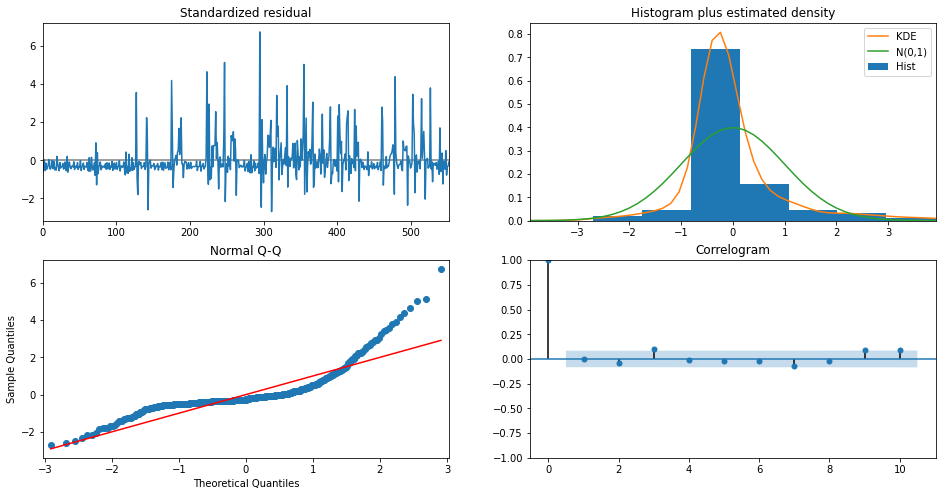

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

So how to interpret the plot diagnostics?

· Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-3, 7).

· Top Right: The density plot does not suggest normal distribution, instead kernel density estimation (KDE) works better to describe the data distribution.

· Bottom left: The most part of the blue dots are out of the red line, so it seems that the distribution is somewhat skewed.

· Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

*3rd MODEL - LSTM NEURAL NETWORK*

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.94564006],
       [-0.9468976 ],
       [-0.90439853],
       [-0.94518277],
       [-0.9204893 ],
       [-0.94752637],
       [-0.944554  ],
       [-0.93663723],
       [-0.88933665],
       [-0.91660236]])

In [ ]:
# Defines the rolling window
look_back = 224  # We try to get the maximum allowed. It will be more accurate, though more computationally expensive
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

105 98


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
105/105 [==============================] - 8s 31ms/step - loss: 0.0719 - val_loss: 0.0093
Epoch 2/5
105/105 [==============================] - 1s 12ms/step - loss: 0.0443 - val_loss: 0.0324
Epoch 3/5
105/105 [==============================] - 2s 15ms/step - loss: 0.0598 - val_loss: 0.0086
Epoch 4/5
105/105 [==============================] - 2s 15ms/step - loss: 0.0441 - val_loss: 0.0424
Epoch 5/5
105/105 [==============================] - 2s 15ms/step - loss: 0.0419 - val_loss: 0.0152
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 128)            180736    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

4/4 [==============================] - 0s 10ms/step
RMSE: 1.439291283097394


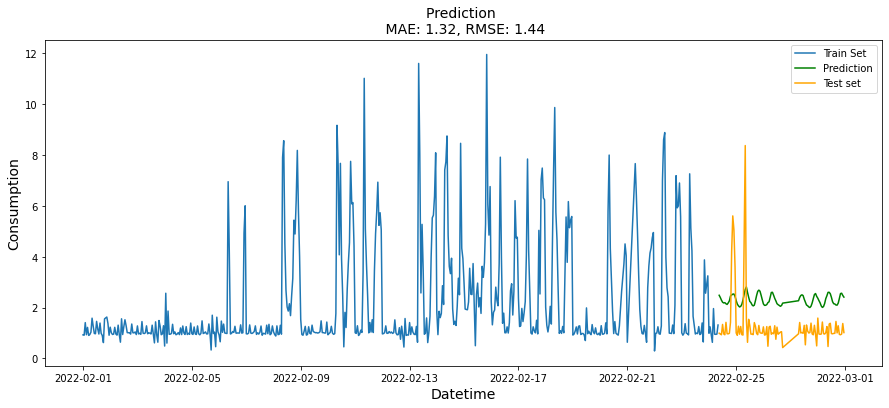

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') 
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') 
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Test set') 

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Datetime', fontsize=14)
ax.set_ylabel(ylabel='Consumption', fontsize=14)

plt.show()

It's worth bearing in mind that Machine Learning algorithms in general are non-deterministic. This means that every time you run them the outcome should vary. This has to do with the random initialization of the weights. If you want to make the results reproducible you have to eliminate the randomness from the table. A simple way to do this is to use a random seed.

Or we can also try to fetch good hyperparameters (look_back, LSTM layers, epochs, neurons, batch size and learning rate) so we can obtain an accurate model and adopt it as our result.

The good news is that LSTM is pretty able to outperform Prophet and ARIMA.